# Universidade Federal de Minas Gerais
## Teoria da Decisão - ELE088 
Daniela Amaral Sampaio - 2017074351

Matheus Brito Faria - 2017074386

Victor Emannuel - 2017074394

Importando as bibliotecas que serão utilizadas

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from copy import deepcopy
import random
import time
from IPython.display import clear_output 
plt.rcParams["figure.figsize"] = (16,9)
%matplotlib inline

Fazendo a importação do drive com as tabelas para o trabalho

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Obtendo os dados do arquivo i5x25.xlsx disponível para o trabalho computacional

In [3]:
path = r'/content/drive/MyDrive/UFMG/9º SEMESTRE/TEORIA DA DECISAO/' \
        'Trabalho-Computacional/i5x25.xlsx'
data = pd.read_excel(path, header=1)
time_job_machine = data[[1, 2, 3, 4, 5]][:25].to_numpy()
cost_late_job = data.iloc[:25, -1].to_numpy()
due_date = data.iloc[-1, 1]

Para montar a estrutura de vizinhança, foi utilizada a estrutura abaixo em que a ordem das tarefas a serem executadas em cada maquina é representado pelo index da tarefa corespondente. 

Portanto, a maquina 0 começa com a tarefa 1 depois a 6 e no fim a 23, nesse exemplo.

```
schedule = [
            [ 1,  6, 14,  7, 23], # machine 0
            [24, 21,  0,  3,  9], # machine 1
            [19, 20, 18,  5, 11], # machine 2
            [ 2, 22, 15, 17, 10], # machine 3
            [13, 16,  8, 12,  4]  # machine 4
]
```


A classe *JobShopScheduler* contém as funções que calculam todos os valores das variáveis, entre eles: calcular o tempo de término da tarefa, calcular o makespan, o objetivo, entre outras.

In [4]:
class JobShopScheduler:
    def __init__(self, 
                 objective_name=None,
                 schedule=None,
                 time_job_machine=time_job_machine, 
                 cost_late_job=cost_late_job, 
                 due_date=due_date):
        self.time_job_machine = time_job_machine
        self.cost_late_job = cost_late_job
        self.due_date = due_date
        self.number_of_machines = time_job_machine.shape[1]
        self.number_of_jobs = time_job_machine.shape[0]
        self.objective_name = objective_name
        self.schedule = schedule if schedule else self.initiate_schedule() 
        self.calculate_time_to_finish()

    def initiate_schedule(self):
        # jobs = np.array(range(self.number_of_jobs))
        # np.random.shuffle(jobs)
        # return np.split(jobs, self.get_random_sizes(4, 25))
        jobs = np.array(range(self.number_of_jobs))
        np.random.shuffle(jobs)
        return np.array_split(jobs, self.number_of_machines)

    def set_schedule(self, schedule):
        self.schedule = schedule
        self.calculate_time_to_finish()
        
    def calculate_time_to_finish(self):
        time_to_finish = np.zeros(self.number_of_jobs)
        for machine, machine_schedule in enumerate(self.schedule):
            late_time = 0
            for job in machine_schedule:
                time_to_finish[job] = self.time_job_machine[job, machine] + late_time
                late_time = time_to_finish[job]
        self.time_to_finish = time_to_finish 

    def calculate_lateness(self):
        return np.maximum(self.time_to_finish-self.due_date, 
                          np.zeros(self.number_of_jobs))

    def calculate_lateness_cost(self):
        return np.sum(self.calculate_lateness()*self.cost_late_job)

    def calculate_lateness_cost_normalized(self):
        return (self.calculate_lateness_cost() - self.utopic_lateness_cost) / \
                (self.nadir_lateness_cost - self.utopic_lateness_cost)

    def calculate_makespan(self):
        return np.max(self.time_to_finish)

    def calculate_makespan_normalized(self):
        return (self.calculate_makespan() - self.utopic_makespan) / \
                (self.nadir_makespan - self.utopic_makespan)

    def calculate_objective(self):
        if self.objective_name == 'makespan':
            return self.calculate_makespan()
        elif self.objective_name == 'lateness_cost':
            return self.calculate_lateness_cost()
        elif self.objective_name == 'both': 
            return (self.weight*self.calculate_makespan_normalized()) + \
                   ((1-self.weight)*self.calculate_lateness_cost_normalized())
        else:
            raise

    def set_normalization(self, norm_list):
        self.utopic_makespan = norm_list[0]
        self.nadir_makespan = norm_list[1]
        self.utopic_lateness_cost = norm_list[2]
        self.nadir_lateness_cost = norm_list[3]

    def set_weight(self, weight):
        self.weight = weight

    def get_schedule(self):
        return self.schedule

    def get_objective_name(self):
        return self.objective_name

    @staticmethod
    def get_random_sizes(n, total):
        dividers = sorted(random.sample(range(1, total), n - 1))
        return [a - b for a, b in zip(dividers + [total], [0] + dividers)]


# scheduler = JobShopScheduler()
# print(scheduler.calculate_lateness())
# print(scheduler.calculate_lateness_cost())
# print(scheduler.calculate_makespan())

A classe *Shaker* contém diversas funções que executam tipos diferentes de estruturas de vizinhança que podem ser empregadas, como: *shift, switch, task move*, entre outras. 

In [5]:
class Shaker:
    def __init__(self):
        self.schedule_matrix = list
        self.number_of_jobs_in_machine = int

    def set_schedule(self, schedule):
        self.schedule_matrix = deepcopy(schedule.get_schedule())
        self.number_of_machines = len(self.schedule_matrix)
        self.objective_name = deepcopy(schedule.get_objective_name())

    def shift(self):
        number_of_jobs_in_machine = 0
        while number_of_jobs_in_machine < 2:
            machine_index = self.get_random(self.number_of_machines)
            number_of_jobs_in_machine = len(self.schedule_matrix[machine_index])
        job_index, position_index = self.get_random(
            number_of_jobs_in_machine, 2)
        hold_job = self.schedule_matrix[machine_index][job_index]
        self.schedule_matrix[machine_index] = np.delete(
            self.schedule_matrix[machine_index], job_index)
        self.schedule_matrix[machine_index] = np.insert(
            self.schedule_matrix[machine_index], position_index, hold_job)
        return self.schedule_matrix

    def switch(self):
        number_of_jobs_in_machine = 0
        while number_of_jobs_in_machine <= 2:
            machine_index = self.get_random(self.number_of_machines)
            number_of_jobs_in_machine = len(self.schedule_matrix[machine_index])
        job_index, another_job_index = self.get_random(
            number_of_jobs_in_machine, 2)
        self.schedule_matrix[machine_index][[job_index, another_job_index]] = \
        self.schedule_matrix[machine_index][[another_job_index, job_index]]
        return self.schedule_matrix

    def task_move(self):
        size_1 = 0
        while size_1 < 1:
            machine_index_source, machine_index_destination = self.get_random(
                self.number_of_machines, 2)
            size_1 = len(self.schedule_matrix[machine_index_source])
        job_index_source = self.get_random(
            len(self.schedule_matrix[machine_index_source]))
        hold_value = self.schedule_matrix[machine_index_source][job_index_source]
        self.schedule_matrix[machine_index_source] = np.delete(
            self.schedule_matrix[machine_index_source], 
            job_index_source)
        job_index_destination = self.get_random(
            len(self.schedule_matrix[machine_index_destination]))
        self.schedule_matrix[machine_index_destination] = np.insert(
            self.schedule_matrix[machine_index_destination], 
            job_index_destination, 
            hold_value)
        return self.schedule_matrix
    
    def machine_move(self):
        machine_index_1, machine_index_2 = self.get_random(
                self.number_of_machines, 2)
        self.schedule_matrix[machine_index_1], self.schedule_matrix[machine_index_2] = \
        self.schedule_matrix[machine_index_2], self.schedule_matrix[machine_index_1]
        return self.schedule_matrix

    def swap(self):
        machine_index_1, machine_index_2 = self.get_random(
            self.number_of_machines, 2)
        if len(self.schedule_matrix[machine_index_1]) < 1 or \
            len(self.schedule_matrix[machine_index_2]) < 1:
                return self.schedule_matrix
        job_index_source_1 = self.get_random(
            len(self.schedule_matrix[machine_index_1]))
        hold_value_1 = self.schedule_matrix[machine_index_1][job_index_source_1]
        self.schedule_matrix[machine_index_1] = np.delete(
            self.schedule_matrix[machine_index_1], 
            job_index_source_1)
        job_index_destination_2 = self.get_random(
            len(self.schedule_matrix[machine_index_2]))
        self.schedule_matrix[machine_index_2] = np.insert(
            self.schedule_matrix[machine_index_2], 
            job_index_destination_2, 
            hold_value_1)
        job_index_source_2 = self.get_random(
            len(self.schedule_matrix[machine_index_2]))
        hold_value_2 = self.schedule_matrix[machine_index_2][job_index_source_2]
        self.schedule_matrix[machine_index_2] = np.delete(
            self.schedule_matrix[machine_index_2], 
            job_index_source_2)
        job_index_destination_1 = self.get_random(
            len(self.schedule_matrix[machine_index_1]))
        self.schedule_matrix[machine_index_1] = np.insert(
            self.schedule_matrix[machine_index_1], 
            job_index_destination_1, 
            hold_value_2)
        return self.schedule_matrix

    def shake(self, schedule, level_change):
        self.set_schedule(schedule)
        new_schedule = deepcopy(schedule)
        if level_change == 1:
            new_schedule.set_schedule(self.shift())
        elif level_change == 2:
            new_schedule.set_schedule(self.switch())
        elif level_change == 3:
            new_schedule.set_schedule(self.task_move())
        else:
            new_schedule.set_schedule(self.swap())
        # else:
        #     jobs = np.array(range(25))
        #     np.random.shuffle(jobs)
        #     new_schedule.set_schedule(np.array_split(jobs, 5))
        return new_schedule

    @staticmethod
    def get_random_sizes(n, total):
        dividers = sorted(random.sample(range(1, total), n - 1))
        return [a - b for a, b in zip(dividers + [total], [0] + dividers)]

    @staticmethod
    def get_random(low, size=None):
        try:
            if size == 1 or not size:
                try:
                    return np.random.randint(low)
                except:
                    return 0
            else:
                return np.random.choice(range(low), size, replace=False)
        except:
            print(low, size)

# shaker = Shaker()
# print(scheduler.get_schedule())
# new = shaker.shake(scheduler, 4)
# print(new.get_schedule())

Se a nova vizinhança tiver um valor da função objetiva menor que a anterior, retorna-se 1 e se inicia uma nova *schedule*. Caso contrário, passa para o próximo nível para analisar mais vizinhanças.

In [6]:
def neighborhood_change(schedule, new_schedule, level_change):
    if schedule.calculate_objective() <= new_schedule.calculate_objective():
        return level_change+1, schedule 
    else:
        return 1, new_schedule

In [7]:
def first_improvement_stochastic(schedule, level_change, max_attempts=100):
    shaker = Shaker()
    objective_target = schedule.calculate_objective()
    new_schedule = shaker.shake(deepcopy(schedule), level_change)
    attempts = 0
    while attempts <= max_attempts and \
        objective_target <= new_schedule.calculate_objective():
        new_schedule = shaker.shake(schedule, level_change)
        attempts +=1
    return new_schedule

Nessa função *run_vns*, executa-se a metaheurística RVNS, que é uma variação do VNS. A cada iteração do VNS, parte-se da solução corrente para obter uma solução vizinha aleatória dentro de uma vizinhança k ∈ K. O adicional dessa metaheurística é que esta solução vizinha é então submetida a uma busca local. 

Se a solução gerada for melhor do que a solução corrente, a busca continua a partir dela, retornando-se à primeira estrutura de vizinhança. Caso contrário, continua-se a busca a partir da próxima estrutura de vizinhança k + 1 ∈ K. 



In [8]:
def run_vns(objective_name, 
            max_iteration=100, 
            norm_list=None, 
            weight=None, 
            last_solution=None):

    iteration = 0
    list_lateness_cost = list()
    list_makespan = list()

    schedule = JobShopScheduler(objective_name, 
                                schedule=last_solution)
    if norm_list is not None:
        schedule.set_normalization(norm_list)
    if weight is not None:
        schedule.set_weight(weight)
        
    shaker = Shaker()

    list_lateness_cost.append(schedule.calculate_lateness_cost())
    list_makespan.append(schedule.calculate_makespan())

    while iteration < max_iteration:
        level_change = 1
        while level_change <= 4:
            new_schedule = shaker.shake(schedule, 
                                        level_change)
            new_schedule = first_improvement_stochastic(new_schedule, 
                                                        level_change)
            level_change, schedule = neighborhood_change(schedule, 
                                                         new_schedule, 
                                                         level_change)

        list_lateness_cost.append(schedule.calculate_lateness_cost())
        list_makespan.append(schedule.calculate_makespan())

        iteration += 1

    return schedule, list_lateness_cost, list_makespan

# schedule, list_lateness_cost, list_makespan = run_vns()

In [9]:
def is_optimal_pareto(costs):
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient]<c, axis=1)
            is_efficient[i] = True
    return is_efficient

**Abordagem escalar Soma Ponderada (Pw)**

O método da soma ponderada considera uma soma balanceada das funções a serem otimizadas e é o método mais simples e mais utilizado na otimização de problemas multiobjetivo. Nele, cada objetivo é multiplicado por um peso e então todos são somados em uma única função objetivo.

In [10]:
def run_weighted_sum():
    # Best Latnesse Cost
    schedule, list_lateness_cost, list_makespan = run_vns('lateness_cost')
    utopic_lateness_cost = min(list_lateness_cost)
    nadir_makespan = min(list_makespan)

    # Best makespan
    schedule, list_lateness_cost, list_makespan = run_vns('makespan')
    utopic_makespan = min(list_makespan)
    nadir_lateness_cost = min(list_lateness_cost)

    norm_list = [min(utopic_makespan, nadir_makespan),
                max(utopic_makespan, nadir_makespan),
                min(utopic_lateness_cost, nadir_lateness_cost),
                max(utopic_lateness_cost, nadir_lateness_cost)]

    # print(norm_list)

    best_schedule = list()
    runs_makespan = list()
    runs_lateness_cost = list()
    for i, weight in enumerate(np.random.rand(100)):
        schedule, list_lateness_cost, list_makespan = run_vns(objective_name='both', 
                                                            norm_list=norm_list, 
                                                            weight=weight)
        best_schedule.append(schedule.get_schedule())
        runs_makespan.append(np.array(list_makespan)[-1])
        runs_lateness_cost.append(np.array(list_lateness_cost)[-1])
        costs = np.array(list(zip(runs_makespan, runs_lateness_cost)))
        is_pareto = is_optimal_pareto(costs)

    return list(zip(np.array(runs_makespan)[is_pareto], 
                    np.array(runs_lateness_cost)[is_pareto],
                    np.array(best_schedule)[is_pareto]))

        # clear_output()
        # print(f"Iteration {i}")
        # print(costs[is_pareto])
        # plt.figure(figsize=(16,9))
        # plt.scatter(runs_makespan, runs_lateness_cost, c=is_pareto)
        # plt.show()


In [11]:
start_time = time.time()
best_pareto = list()
for _ in range(5):
    best_pareto.append(run_weighted_sum())
print("--- %s seconds ---" % (time.time() - start_time))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in double_scalars


--- 2378.630854845047 seconds ---


In [12]:
best_pareto

[[(11.0,
   73.0,
   array([array([24, 18,  3, 14, 20]), array([23,  0,  5,  9, 22, 19]),
          array([15, 21,  6, 17, 12]), array([ 8, 11,  1, 16, 10]),
          array([13,  2,  7,  4])], dtype=object)),
  (12.0,
   69.0,
   array([array([24, 11, 18, 20, 14]), array([22,  0, 23,  9,  5, 19]),
          array([ 7, 15,  6, 17, 12]), array([ 8,  1, 21, 16, 10]),
          array([ 3,  2, 13,  4])], dtype=object))],
 [(29.0, 769.0, array([[13,  3, 18, 15, 16],
          [ 5, 20, 22,  4,  2],
          [ 0,  8, 14,  9, 19],
          [21, 23, 11, 17, 10],
          [ 6,  1,  7, 12, 24]])), (28.0, 1072.0, array([[10,  3, 20, 22, 24],
          [ 6,  1, 17,  7,  2],
          [19,  8, 23, 15,  5],
          [11, 16,  0,  9, 18],
          [21,  4, 14, 12, 13]]))],
 [(12.0,
   69.0,
   array([array([11, 24, 18, 20, 14]), array([ 0, 23,  9,  5, 22, 19]),
          array([ 7, 15,  6, 17]), array([21,  1,  8, 16, 10]),
          array([ 3,  2, 13, 12,  4])], dtype=object)),
  (11.0,
   73.0,

In [ ]:
start_time = time.time()
best_pareto = list()
for _ in range(5):
    best_pareto.append(run_weighted_sum())
print("--- %s seconds ---" % (time.time() - start_time))

--- 1814.6382203102112 seconds ---


In [ ]:
best_pareto

[[(12.0, 71.0), (13.0, 67.0), (11.0, 73.0)],
 [(11.0, 74.0), (12.0, 69.0)],
 [(12.0, 69.0), (11.0, 77.0)],
 [(11.0, 73.0), (14.0, 68.0), (12.0, 69.0)],
 [(12.0, 69.0), (11.0, 73.0), (13.0, 67.0)]]

In [ ]:
print(best_pareto[0].sort())

None


In [ ]:
best_pareto

[[(11.0, 73.0), (12.0, 71.0), (13.0, 67.0)],
 [(11.0, 74.0), (12.0, 69.0)],
 [(12.0, 69.0), (11.0, 77.0)],
 [(11.0, 73.0), (14.0, 68.0), (12.0, 69.0)],
 [(12.0, 69.0), (11.0, 73.0), (13.0, 67.0)]]

[11.0, 12.0, 13.0] [73.0, 71.0, 67.0]
[11.0, 12.0] [74.0, 69.0]
[11.0, 12.0] [77.0, 69.0]
[11.0, 12.0, 14.0] [73.0, 69.0, 68.0]
[11.0, 12.0, 13.0] [73.0, 69.0, 67.0]


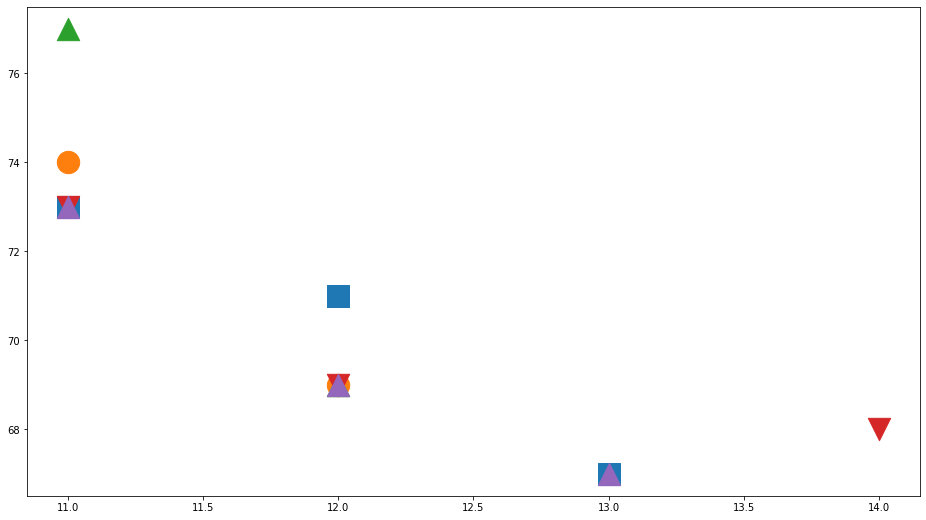

In [ ]:
plt.figure(figsize=(16,9))
markers = ["s" , "o" , "^" , "v" , "^" , "<", ">"]
for i, pareto in enumerate(best_pareto):
    pareto.sort()
    x = [sol[0] for sol in pareto]
    y = [sol[1] for sol in pareto]
    print(x, y)
    plt.scatter(x, y, s=500, marker=markers[i])

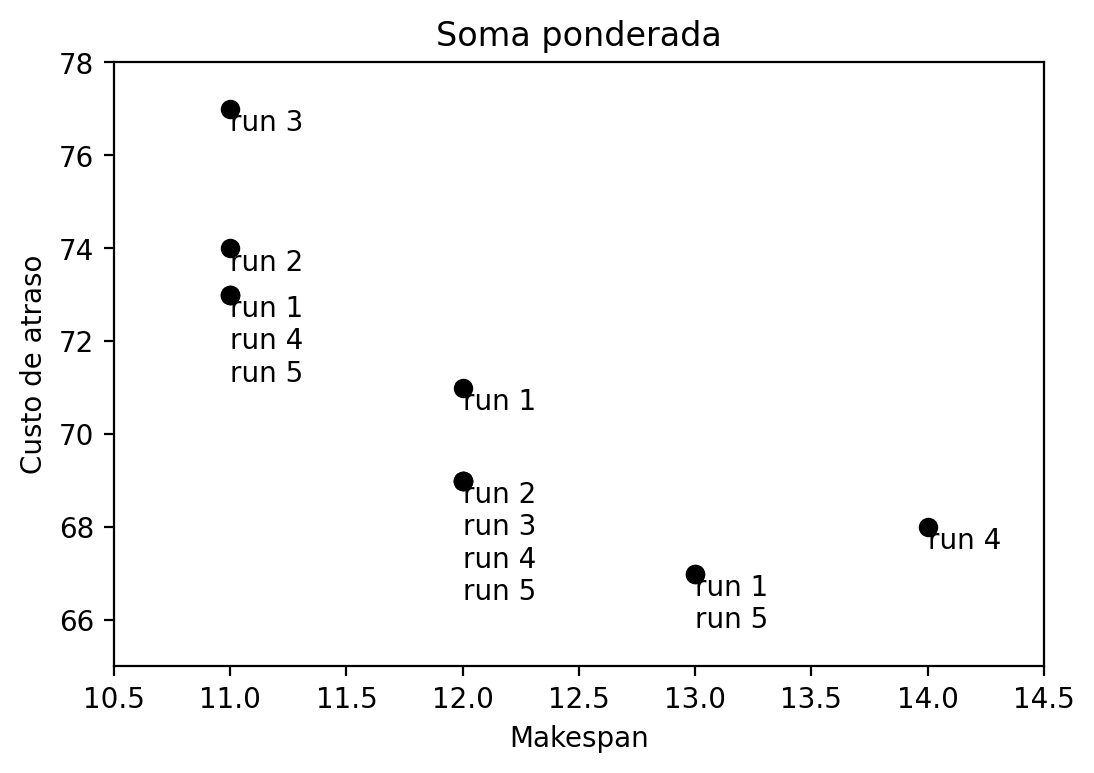

In [ ]:
for i, pareto in enumerate(best_pareto):
    pareto.sort()
    x = [sol[0] for sol in pareto]
    y = [sol[1] for sol in pareto]
    plt.scatter(x, y, color='black')

plt.text(11, 73,"run 1\nrun 4\nrun 5", va='top')

plt.text(12, 71,"run 1", verticalalignment='top')

plt.text(13, 67,"run 1\nrun 5", verticalalignment='top')

plt.text(11, 74,"run 2", verticalalignment='top')

plt.text(12, 69,"run 2\nrun 3\nrun 4\nrun 5", verticalalignment='top')

plt.text(11, 77,"run 3", verticalalignment='top')

plt.text(14, 68,"run 4", verticalalignment='top')

plt.ylim((65, 78))
plt.xlim((10.5, 14.5))

plt.title("Soma ponderada")
plt.xlabel('Makespan')
plt.ylabel('Custo de atraso')
plt.gcf().set_dpi(200)
plt.savefig('soma-poderada.pdf')

Text(0, 0.5, 'Custo de atraso')

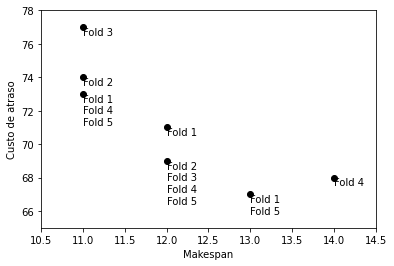

In [ ]:
plt.scatter(11, 73, color='black')
plt.text(11, 73,"run 1\nrun 4\nrun 5", va='top')

plt.scatter(12, 71, color='black')
plt.text(12, 71,"run 1", verticalalignment='top')

plt.scatter(13, 67, color='black')
plt.text(13, 67,"run 1\nrun 5", verticalalignment='top')

plt.scatter(11, 74, color='black')
plt.text(11, 74,"run 2", verticalalignment='top')

plt.scatter(12, 69, color='black')
plt.text(12, 69,"run 2\nrun 3\nrun 4\nrun 5", verticalalignment='top')

plt.scatter(11, 77, color='black')
plt.text(11, 77,"run 3", verticalalignment='top')

plt.scatter(14, 68, color='black')
plt.text(14, 68,"run 4", verticalalignment='top')

plt.ylim((65, 78))
plt.xlim((10.5, 14.5))

plt.xlabel('Makespan')
plt.ylabel('Custo de atraso')

In [ ]:
# plt.figure(figsize=(16,9))
# plt.scatter(np.array(runs_makespan)[is_pareto], 
#             np.array(runs_lateness_cost)[is_pareto])
# plt.show()

[[12. 75.]
 [11. 83.]]

 [[11. 78.]]

 [[13. 71.]
 [11. 78.]]

12 69
